## Moloko Studio Insights

Фотостудия Luce+Moloko предоставляет в аренду залы для проведения фотосессий. У студии накоплена статистика бронирований и отказов за два с половиной года. Задача: Исследовать данные и Максимизировать загрузку фото студий, повысить выручку и улучшить клиентский сервис за счёт анализа данных бронирований и финансов.

**Бизнес-задачи и выгоды:**
Анализ загрузки залов по дням и часам
→ Выгода: пересмотр цен в часы пикового спроса, скидки в “мертвые часы”, более эффективное планирование расписания.

**Прогнозирование выручки и бронирований**: планирование бюджета, закупок, персонала (освободить студию или наоборот нанять ассистента на горячие дни).

**Кластеризация клиентов (новички, постоянные, крупные заказы и т.д.)**: таргетированные предложения, персонализированные скидки.

**Анализ доп. услуг (гримёрка, вентиляторы и т.д.)**: понять, какие услуги реально востребованы и на каких можно заработать больше.

**Раннее определение “провальных” дней**: возможность запустить рекламную акцию или коллаборацию заранее.

**Аномалии в бронированиях и неоплаченные заказы**: минимизация финансовых потерь, работа с "просроченными".

**План работы**
1. Загрузка, первичный анализ и предобработка данных

- Загрузить предоставленные заказчиком таблицы.
- Изучить структуру данных: количество строк и столбцов, наличие пропусков, типы переменных.
- Проверить и обработать пропуски, аномалии и некорректные значения.
- Привести названия столбцов к единому и удобному формату.
- Объединить таблицы в единый датафрейм.

2. Анализ данных

- Провести исследовательский анализ объединённого датафрейма.
- Визуализировать структуру и распределение признаков.
- Выделить наиболее проблемные группы по критериям:


In [1]:
# 1. Импорт базовых библиотек для анализа и визуализации
import re
import pandas as pd                      # Работа с таблицами
import numpy as np                       # Числовые вычисления
import seaborn as sns                    # Визуализация
import matplotlib.pyplot as plt          # Графики
from datetime import datetime, timedelta

# 2. Импорт библиотеки для расчёта Phi-корреляций
import phik 
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Функции для групповых графиков - group_graph.py
from group_graph import hist_graph, bar_graph, kde_graph_count, kde_graph

# 9. Настройки системы предупреждений
import warnings
warnings.filterwarnings("ignore")

# 10. Общие настройки таблиц и графиков
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")

# 11. Установка констант для воспроизводимости
RANDOM_STATE = 210425     # Фиксированный random seed
TEST_SIZE = 0.25          # Доля тестовой выборки


## Загрузка и обработка данных

In [2]:
# 1. Загрузка  датасета
df_moloko = pd.read_csv('dataset/Moloko_1.0.csv', sep=';')
# 2. Загрузка  датасета
df_luce = pd.read_csv('dataset/Luce+Moloko_2.0.csv', sep=';')

### Переименование столбцов

In [3]:
# 1. Список названий всех колонок (по согласованному шаблону)
col_name = [
    'id', 'location', 'hall', 'user_name', 'phone', 'payment_method', 'status', 'purpose',
    'extras', 'people_count', 'amount', 'prepaid', 'booking_date', 'start_h', 'end_h',
    'timeout', 'comment', 'promo_code', 'dur_h', 'utm_source', 'utm_medium', 'utm_campaign',
    'utm_content', 'utm_term'
]
df_moloko.columns = col_name
df_luce.columns = col_name

### Объединение таблиц,

In [4]:
# 3. Объединение всех таблиц в одну
df_main = pd.concat([df_moloko, df_luce], ignore_index=True)

# 4. Убираем технические записи: user_name = 'Скородумова' (рабочая заглушка)
df_main = df_main[~df_main['user_name'].str.replace('C', 'С').str.contains('Скородумова', na=False)].reset_index()

# 5. Сохранение результата
df_main.to_csv('dataset/studio_data.csv', index=False)

df_main.sample(3)

,index,id,location,hall,user_name,phone,payment_method,status,purpose,extras,people_count,amount,prepaid,booking_date,start_h,end_h,timeout,comment,promo_code,dur_h,utm_source,utm_medium,utm_campaign,utm_content,utm_term
10427,13717,2901931,Moloko 2.0,Малый,Василиса Елагина,+7 917 541 25 74,Онлайн оплата,Завершено,Фотосъемка,NaN,2.00,1800,900,23.04.2025,15,16,19.04.2025 10:54,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2340,3068,2129420,Moloko,ЧБ,Алина Воронова,+7 915 822 57 17,Онлайн оплата,Завершено,Фотосъемка,NaN,4.00,1600,800,16.10.2023,19,20,15.10.2023 12:18,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
10648,14062,2922688,Moloko 2.0,Большой,Ольга Федотова,+7 916 934 39 06,Онлайн оплата,Забронировано,Фотосъемка,NaN,1.00,4400,2200,11.05.2025,13,15,09.05.2025 21:58,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN


In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           10661 non-null  int64  
 1   id              10661 non-null  int64  
 2   location        10661 non-null  object 
 3   hall            10661 non-null  object 
 4   user_name       10661 non-null  object 
 5   phone           10661 non-null  object 
 6   payment_method  10661 non-null  object 
 7   status          10661 non-null  object 
 8   purpose         10661 non-null  object 
 9   extras          2098 non-null   object 
 10  people_count    10649 non-null  float64
 11  amount          10661 non-null  int64  
 12  prepaid         10661 non-null  int64  
 13  booking_date    10661 non-null  object 
 14  start_h         10661 non-null  int64  
 15  end_h           10661 non-null  int64  
 16  timeout         10661 non-null  object 
 17  comment         1699 non-null  

### Распределение значений

Проверяем распределение значений ключевых признаков.

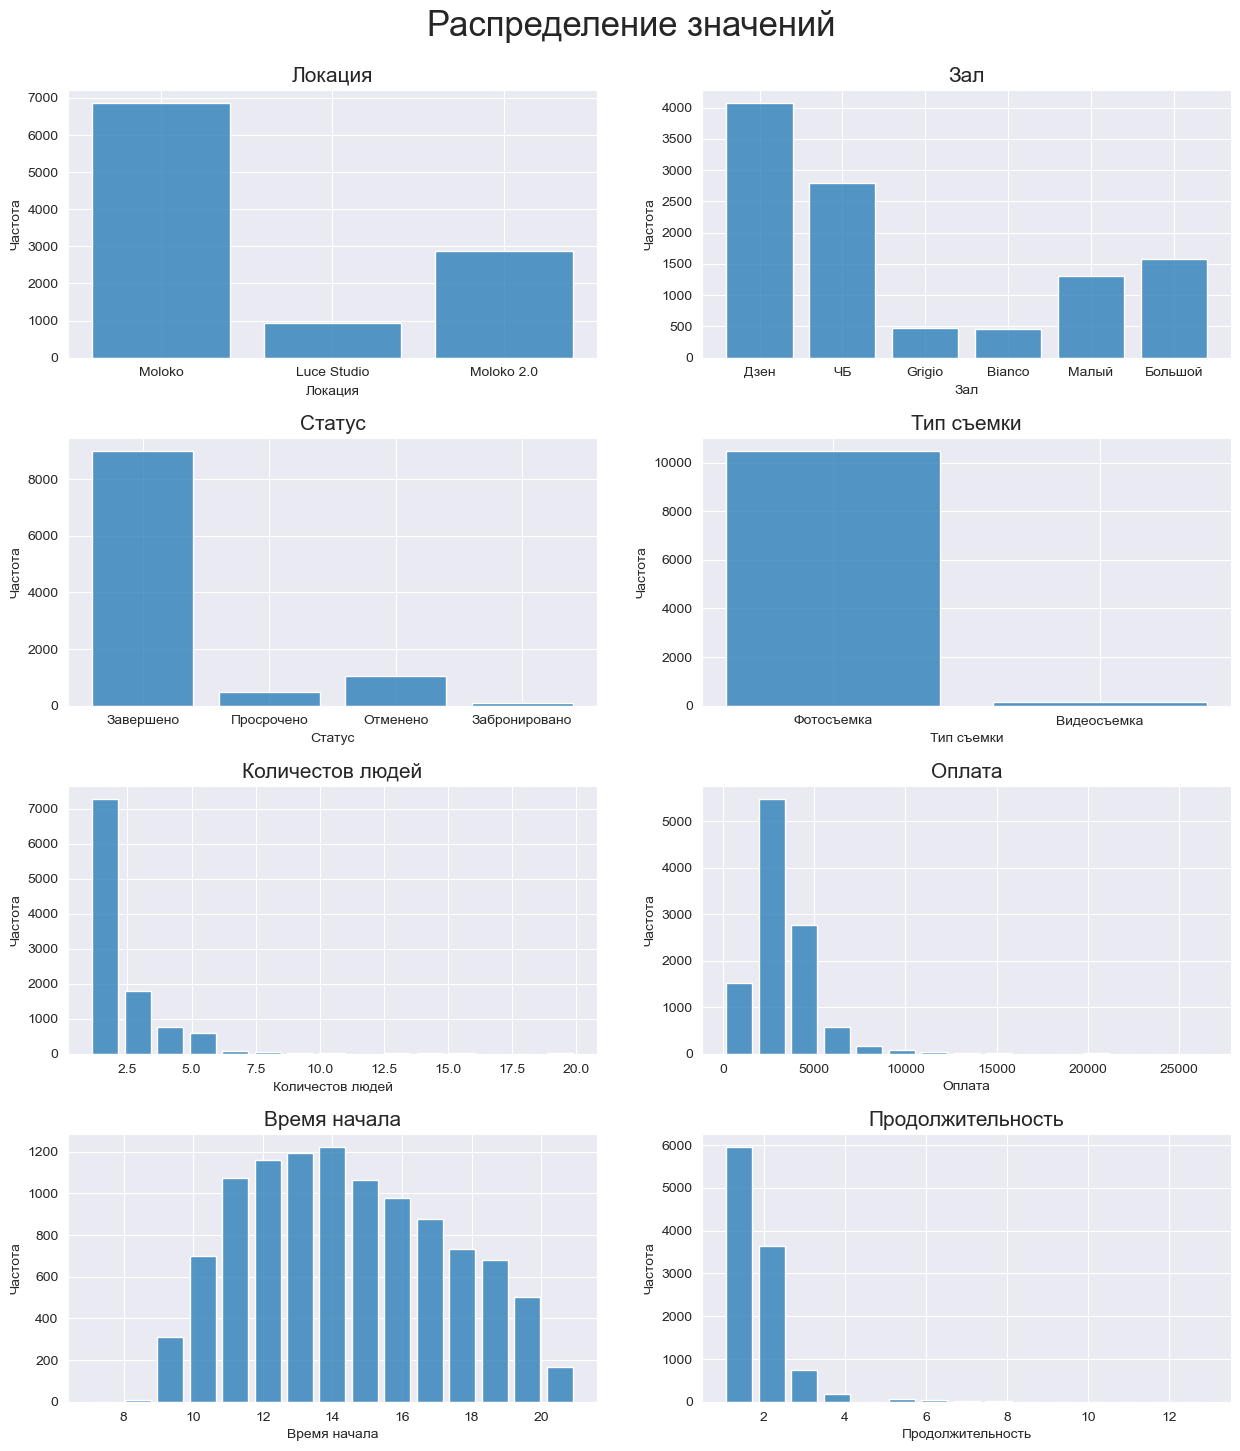

In [6]:
#Параметры для построения графиков
list_param = [
    'location', 'hall', 'status', 'purpose',
    'people_count', 'amount',  'start_h', 'dur_h'
]

#Наименования параметров для построения графиков
list_name_param = [
    'Локация', 'Зал',  'Статус', 'Тип съемки',
    'Количестов людей', 'Оплата',  'Время начала', 'Продолжительность'
]
#Заголовок листа
suptitle = 'Распределение значений'

#Построение графиков
hist_graph (df_main,list_param,list_name_param , suptitle)

**Локации и Залы:**   
Самая загруженная локация — Moloko (более 2/3 всех бронирований).
Luce Studio используется гораздо реже.
По залам лидирует «Дзен» и «ЧБ» — на них приходится большая часть съёмок.
Залы Grigio и Bianco — почти не используются → возможен вывод из аренды или перезапуск с другим позиционированием.

**Оплата и Статусы:**   
95% клиентов платят онлайн — удобно, безопасно, экономит время.
Основной статус — «Завершено», но есть значительная доля отменённых и просроченных бронирований, с которыми стоит работать (например, напоминания, депозиты, фильтр «ненадёжных»).

**Тип съёмки и поведение клиентов:**   
Почти все бронирования — фотосъёмки, видеосъёмки — единичны. Это может быть точкой роста (предложить спецпакеты для видео?).
Обычно приходит 1–2 человека.
Чаще всего бронируют 1–2 часа, иногда — до 3–4.
Начинают снимать чаще всего в интервале с 11:00 до 15:00 (пик в районе 13:00).

**Деньги:**    
Большинство съёмок — на средние чеки (2000–4000₽).
Предоплата чаще всего соответствует половине стоимости — стандартная и, судя по всему, приемлемая схема.

## Исследовательский анализ данных.
Описываем и визуализируем общую информацию о пользователях и залах.
1) добавляем необходимые поля Год, день недели, месяц. Доп расходы, Стоимость аренды зала - приведенная (к текущей дате, что бы исключить влияние инфляции).
2) Анализ пользователей. Ядро. Постоянных клиентов. Клиенты с продолжительной арендой;

3) - заполняемость залов (тепловая карта);
- анализировать сезонность,
строить тепловые карты по дням недели и часам,
- разделять стоимость аренды на будни и выходные
  
4) - количество дополнительных услуг и их стоимость;
- понять, какие услуги реально востребованы и на каких можно заработать больше.

### Дополнительные признаки

**Дополнительные расходы**

In [7]:
extras_prices = {
    "гримерная": 300,
    "проектор": 500,
    "дым-машина": 300,
    "инструктаж по свету": 1500,
    "журавль стойка": 300,
    "ассистент на съёмку": 500,
    "бумажный фон": 500,
    "покраска циклорамы": 1000
}

def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def calculate_extras_cost_robust(extras_str):
    if pd.isna(extras_str):
        return 0
    extras_str = normalize(extras_str)
    total = 0
    for service_key, price in extras_prices.items():
        pattern = rf"{re.escape(service_key)}\s*x\s*(\d+)"
        match = re.search(pattern, extras_str)
        if match:
            total += int(match.group(1)) * price
    return total

#рассчет столбца:
df_main['extras_cost'] = df_main['extras'].apply(calculate_extras_cost_robust)

**Год, День, месяц. Аренда.**    
Почасовая аренда зала в пересчете на текущие цены, что бы можно было сравнивать

In [8]:
# Преобразуем дату бронирования
df_main["booking_date"] = pd.to_datetime(df_main["booking_date"], format="%d.%m.%Y", errors='coerce')
# Оставляем только завершенные бронирования.
df_main= df_main[df_main['status']=='Завершено']
# Оставляем только бронирования с 9:00 - 22:00.
df_main= df_main[df_main['start_h']>=9]


# Извлекаем календарные признаки
df_main["weekday"] = df_main["booking_date"].dt.day_name()
df_main["month"] = df_main["booking_date"].dt.month
df_main["year"] = df_main["booking_date"].dt.year


# Базовые тарифы (будни, выходные)
hall_rates = {
    "Bianco": (1600, 1800),
    "Grigio": (1600, 1800),
    "ЧБ": (1800, 1800),
    "Дзен": (1800, 1800),
    "Малый": (1800, 1800),
    "Большой": (2000, 2200)
}

# Расчёт стоимости аренды
def calculate_rent(row):
    hall = str(row["hall"])
    duration = row["dur_h"]
    weekday = row["weekday"]

    if pd.isna(duration) or hall not in hall_rates:
        return None

    is_weekend = weekday in ["Saturday", "Sunday"]
    rate = hall_rates[hall][1] if is_weekend else hall_rates[hall][0]
    return rate * duration

# Применяем функцию
df_main["rent_estimate"] = df_main.apply(calculate_rent, axis=1)

In [9]:
df_main[['extras_cost','extras']][df_main['extras_cost']>0]

,extras_cost,extras
0,300,Гримерная x 1
21,900,Гримерная x 3
23,300,Гримерная x 1
26,300,Гримерная x 1
35,600,Гримерная x 2
...,...,...
10515,300,дым-машина x 1
10530,500,бумажный фон x 1
10550,300,дым-машина x 1
10554,1000,бумажный фон x 2


In [10]:
# 5. Сохранение результата
df_main.to_csv('dataset/studio_data_anc.csv', index=False)

### Phik корелляция

Корреляционный анализ признаков с учётом смешанных типов.   
Помогает выявить сильные и слабые связи между признаками перед построением моделей.

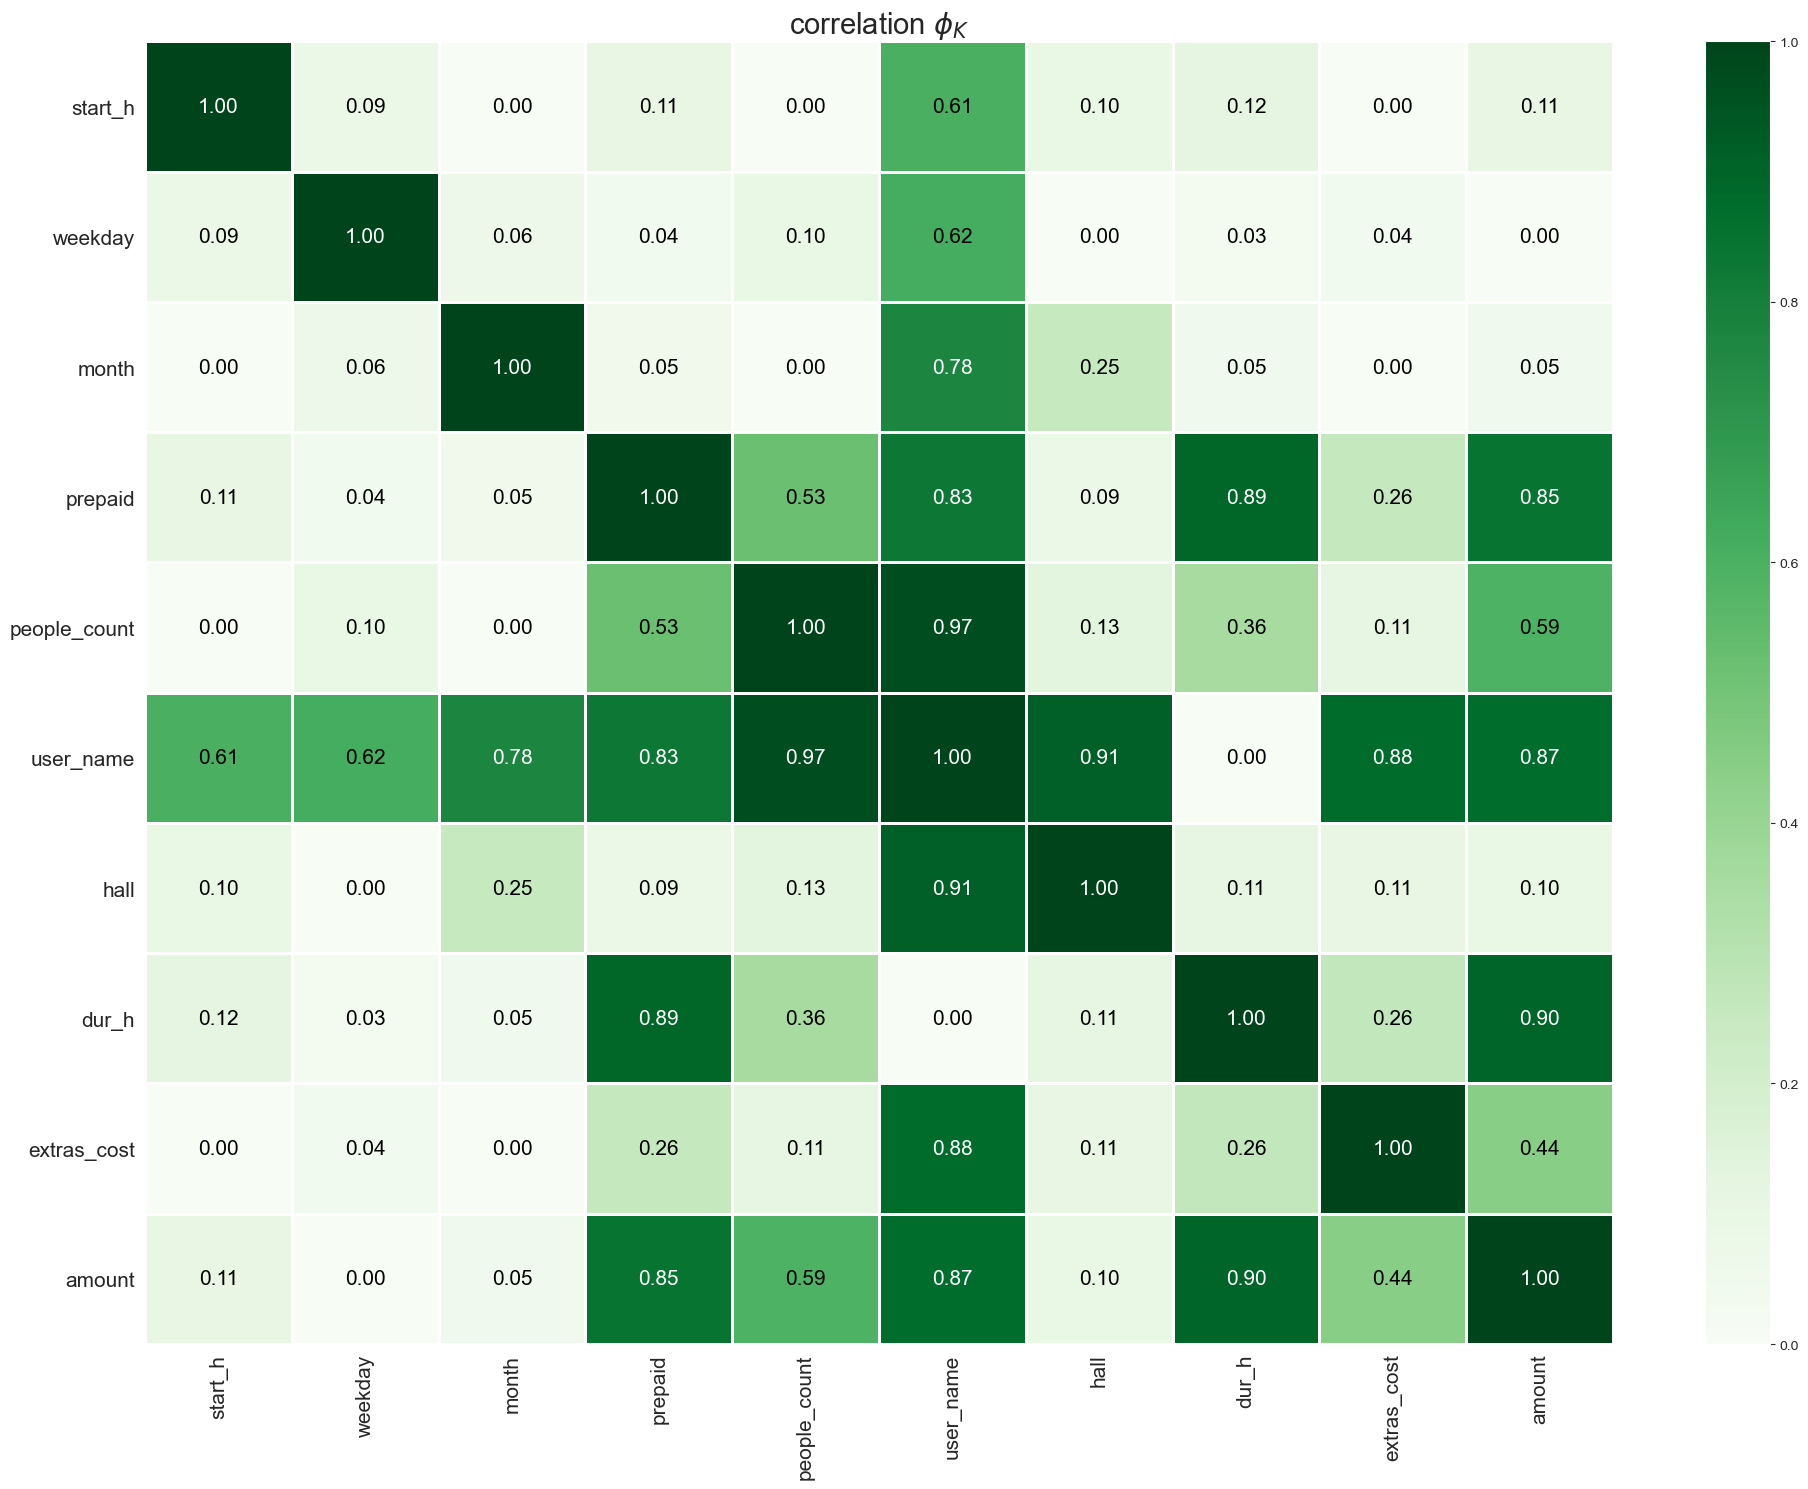

In [11]:
col_phik = [ 
    'amount', 'extras_cost' , 'dur_h',
    'hall', 'user_name', 'people_count', 'prepaid', 
    'month', 'weekday', 'start_h' 
]

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_main[col_phik].sample(3000), interval_cols = ['amount', 'extras_cost','prepaid'] )

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
);

### Анализ клиентов

In [12]:
pivot = df_main.pivot_table(
    index=['user_name', 'phone'],
    values=['rent_estimate','extras_cost', 'dur_h', 'people_count'],
    aggfunc={ 'dur_h':['median'], 'extras_cost':['sum'], 'people_count':['median'], 'rent_estimate':['count', 'sum']}
).reset_index()

# Переименуем колонки для удобства
pivot.columns = ['user_name', 'phone','dur_med', 'sum_cost', 'people_med', 'count_rent', 'sum_rent']

# Сортировка по сумме
pivot_sorted = pivot.sort_values('sum_rent', ascending=False)

pivot_sorted.head(5)

,user_name,phone,dur_med,sum_cost,people_med,count_rent,sum_rent
1131,Андрей Миронов,+7 967 244 34 84,2.00,0,3.00,64,245800
1779,Вероника Сержантова,+7 925 170 11 44,2.00,0,1.00,28,107200
4470,Ника Бестужева,+7 909 939 93 09,3.00,0,1.00,22,104400
2191,Дарья Клепикова,+7 929 671 63 55,2.00,5000,1.00,30,102000
184,Айгузель Амангильдина,+7 925 356 88 48,1.00,1300,3.00,35,81400


Рейтинг прибыльных клиентов и сегментация через KMeans

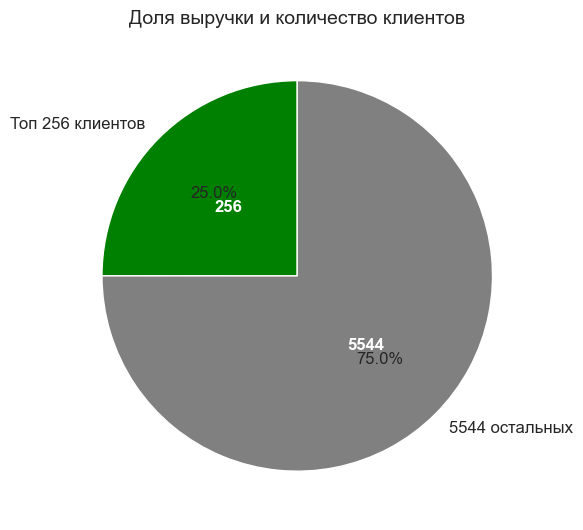

In [13]:
# 1. Добавляем долю в прибыли
pivot_sorted["cum_rent"] = pivot_sorted["sum_rent"].cumsum() / pivot_sorted["sum_rent"].sum()

# Вычисления как раньше
top_clients_30 = pivot_sorted[pivot_sorted["cum_rent"] <= 0.25]
n_top_clients = len(top_clients_30)
total_clients = len(pivot_sorted)
other_clients = total_clients - n_top_clients

# Данные для круговой диаграммы
sizes = [top_clients_30["sum_rent"].sum(), pivot_sorted["sum_rent"].sum() - top_clients_30["sum_rent"].sum()]
labels = [f'Топ {n_top_clients} клиентов', f'{other_clients} остальных']
colors = ['green', 'gray']

# Построение круговой диаграммы
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

# Добавим количество клиентов внутри секторов
for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 + wedge.theta1) / 2
    x = wedge.r * 0.5 * np.cos(np.deg2rad(ang))
    y = wedge.r * 0.5 * np.sin(np.deg2rad(ang))
    client_count = n_top_clients if i == 0 else other_clients
    ax.text(x, y, f'{client_count}', ha='center', va='center', fontsize=12, color='white', weight='bold')

ax.set_title('Доля выручки и количество клиентов', fontsize=14)
plt.tight_layout()

plt.show()

,client_count,dur,cost,people,rent_count,rent_amount
cluster,,,,,,
0,1384,2.50,137.10,3.80,1.40,"6,075.90"
1,4288,1.30,69.20,1.80,1.30,"3,128.20"
2,127,1.70,"1,491.30",2.00,11.10,"32,407.90"


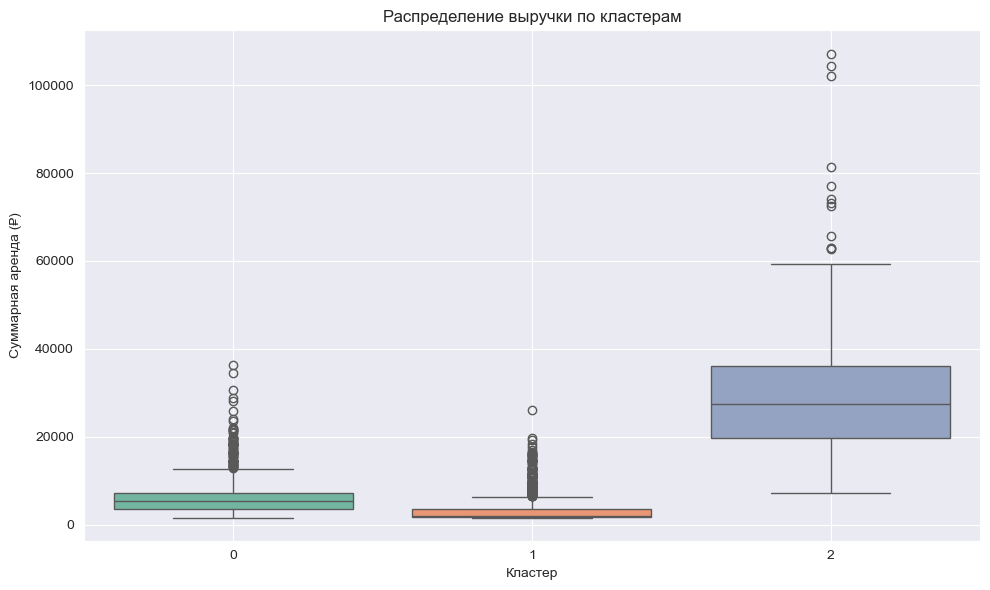

In [14]:
pivot_sorted = pivot_sorted[pivot_sorted['sum_rent'] <150000] 
# 1. Выбор признаков
features = pivot_sorted[["dur_med", "sum_cost", "people_med", "count_rent", "sum_rent"]].fillna(0)

# 2. Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pivot_sorted["cluster"] = kmeans.fit_predict(X_scaled)

# 4. Сводка по кластерам
# Средние значения по кластерам
cluster_means = pivot_sorted.groupby("cluster")[["dur_med", "sum_cost", "people_med", "count_rent", "sum_rent"]].mean().round(1)
cluster_means.columns = ['dur','cost','people','rent_count','rent_amount']

# Количество клиентов в каждом кластере
cluster_counts = pivot_sorted.groupby("cluster").size().rename("client_count")

# Объединяем
cluster_summary = pd.concat([cluster_counts, cluster_means], axis=1)
display(cluster_summary)

# 5. Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=pivot_sorted, x="cluster", y="sum_rent", palette="Set2")
plt.title("Распределение выручки по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Суммарная аренда (₽)")
plt.grid(True)
plt.tight_layout()
plt.show()

Возможно интересной задачей было бы перетащить хотя бы 10% Кластера 1 в Кластер 2. это увеличило бы выручку на 25%
Важно заниматься удержанием Сегмента 1. Абонементы, скидочные карты и и т.д... Т.е. стимулировать их не снимать больше, а вместо других залов снимать в ваших. 

### Анализ залов

Доход по полю amount — это сумма, которую внёс клиент (может включать аренду, доп.услуги и скидки/предоплаты), сглаженная по 3 месяцам.

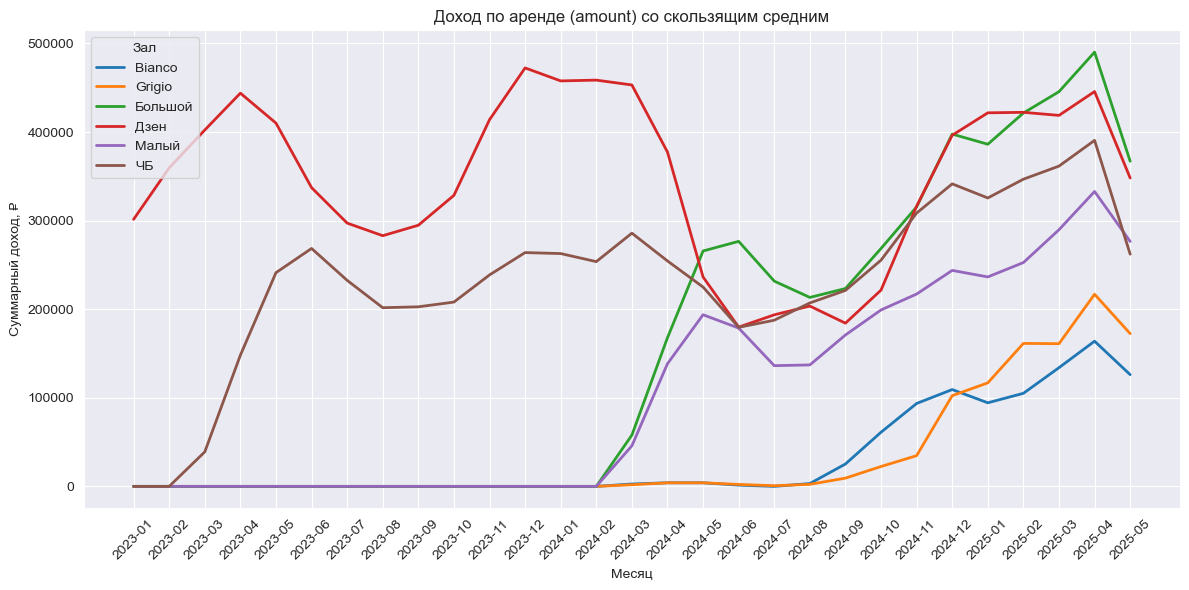

In [15]:
# 1. Загрузка данных
#df = pd.read_csv("studio_data_anc.csv", parse_dates=["booking_date"])

# 2. Фильтрация и подготовка
df = df_main # df[df["booking_date"].notna()]
df["year_month"] = df["booking_date"].dt.to_period("M").astype(str)

# 3. Помесячный доход по залам
monthly_rent = df.pivot_table(
    index="year_month",
    columns="hall",
    values="amount",
    aggfunc="sum"
).fillna(0)

# 4. Скользящее среднее (3 месяца)
monthly_rent_smooth = monthly_rent.rolling(window=3, min_periods=1).mean()

# 5. Визуализация
plt.figure(figsize=(12, 6))
for hall in monthly_rent_smooth.columns:
    plt.plot(monthly_rent_smooth.index, monthly_rent_smooth[hall], label=hall, linewidth=2)

plt.title("Доход по аренде (amount) со скользящим средним")
plt.xlabel("Месяц")
plt.ylabel("Суммарный доход, ₽")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Зал")
plt.tight_layout()
plt.show()


Заполняемость по часам, сглаженная по 3 месяцам.

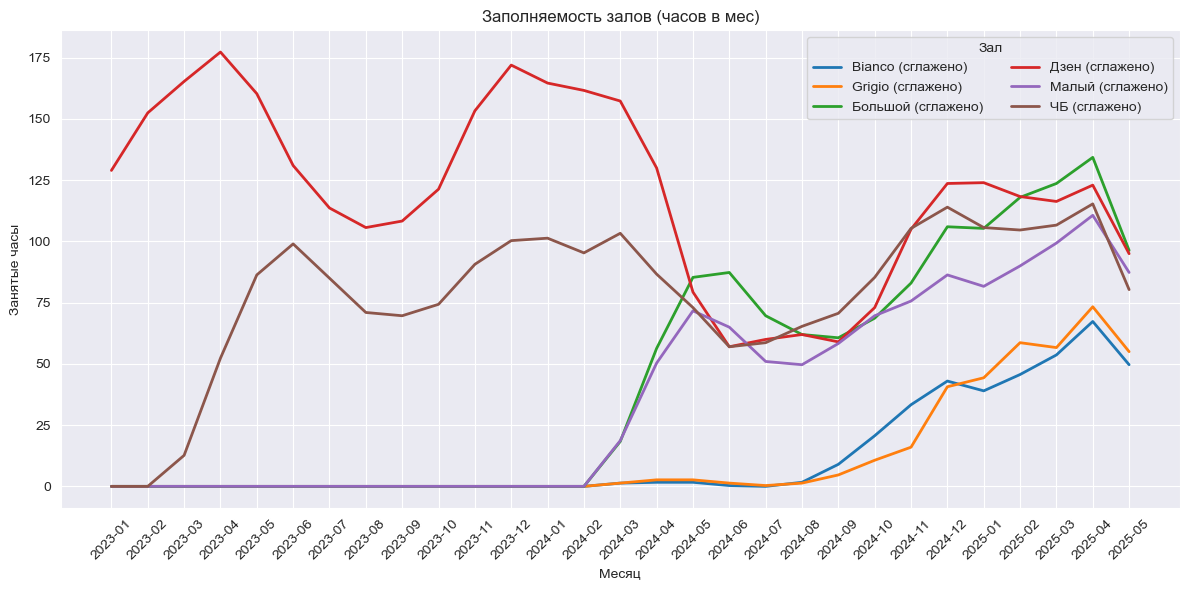

In [16]:
# 3. Количество занятых часов по залам
monthly_hours = df.groupby(["year_month", "hall"]).size().unstack().fillna(0)

# 4. Скользящее среднее (3 месяца)
monthly_hours_smooth = monthly_hours.rolling(window=3, min_periods=1).mean()

# 5. Визуализация
plt.figure(figsize=(12, 6))
for hall in monthly_hours.columns:
    plt.plot(monthly_hours_smooth.index, monthly_hours_smooth[hall], label=f"{hall} (сглажено)", linewidth=2)

plt.title("Заполняемость залов (часов в мес)")
plt.xlabel("Месяц")
plt.ylabel("Занятые часы")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Зал", ncol=2)
plt.tight_layout()
plt.show()

Залы показывают совпадающие тренды.
Самые доходные залы, очень близкие по заполняемости и доходности "Дзен", "ЧБ", "Малый", "Большой"
Два зала с низкой заполняемостью и доходностью Grigio и Bianco

Тренд заполняемости и роста стоимости аренды. Среднее кол-во часов для зала в месяц. Для достоверности возьмем только залы, которые работают больше года. "Дзен", "ЧБ", "Малый", "Большой"

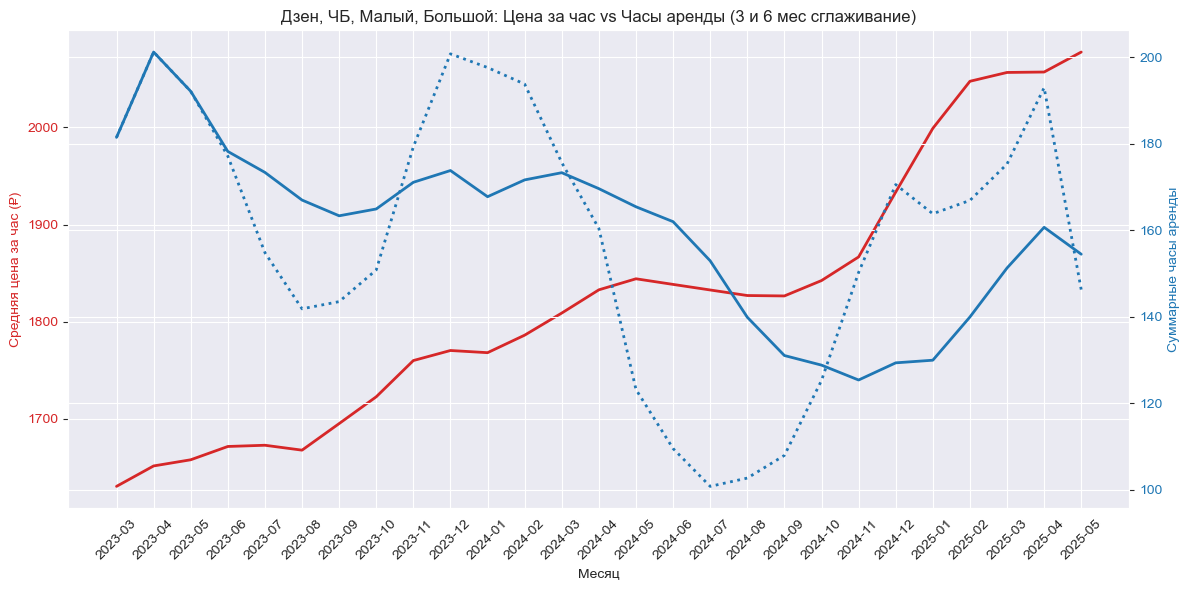

In [17]:
# Перерасчёт тренда, если данные были утеряны
selected_halls = ["Дзен", "ЧБ", "Малый", "Большой"]
df = df_main[
    (df_main["hall"].isin(selected_halls)) &
    (df_main["booking_date"] >= "2023-03-01") &
    (df_main["dur_h"] > 0)
].copy()

df["base_rent"] = (df["amount"] - df["extras_cost"]) / df["dur_h"]
df["year_month"] = df["booking_date"].dt.to_period("M").astype(str)

df_tr = df.groupby(["hall","year_month"]).agg({
    "base_rent": "mean",
    "dur_h": "sum"
}).rename(columns={
    "base_rent": "base_rent",
    "dur_h": "dur_h"
}).dropna()

df_trend = df_tr.groupby(["year_month"]).agg({
    "base_rent": "mean",
    "dur_h": "mean"
}).rename(columns={
    "base_rent": "avg_price_per_hour",
    "dur_h": "total_hours"
}).dropna()

# Добавим скользящие средние
df_trend["avg_price_smooth"] = df_trend["avg_price_per_hour"].rolling(window=3, min_periods=1).mean()
df_trend["total_hours_smooth_3"] = df_trend["total_hours"].rolling(window=3, min_periods=1).mean()
df_trend["total_hours_smooth_6"] = df_trend["total_hours"].rolling(window=9, min_periods=1).mean()

# Визуализация
fig, ax1 = plt.subplots(figsize=(12, 6))

# Красная линия — цена за час (3 мес сглаживание)
ax1.set_xlabel("Месяц")
ax1.set_ylabel("Средняя цена за час (₽)", color="tab:red")
ax1.plot(df_trend.index, df_trend["avg_price_smooth"], label="Цена (3 мес)", color="tab:red", linewidth=2)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax1.set_xticklabels(df_trend.index, rotation=45)

# Синие линии — часы аренды (3 мес и 6 мес сглаживание)
ax2 = ax1.twinx()
ax2.set_ylabel("Суммарные часы аренды", color="tab:blue")
ax2.plot(df_trend.index, df_trend["total_hours_smooth_3"], label="Часы (3 мес)", color="tab:blue", linestyle='dotted', linewidth=2)
ax2.plot(df_trend.index, df_trend["total_hours_smooth_6"], label="Часы (6 мес)", color="tab:blue", linewidth=2)
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.title("Дзен, ЧБ, Малый, Большой: Цена за час vs Часы аренды (3 и 6 мес сглаживание)")
fig.tight_layout()
plt.grid(True)
plt.show()

# 5. Сохранение результата
df_trend.to_csv('dataset/trend_data.csv', index=False)

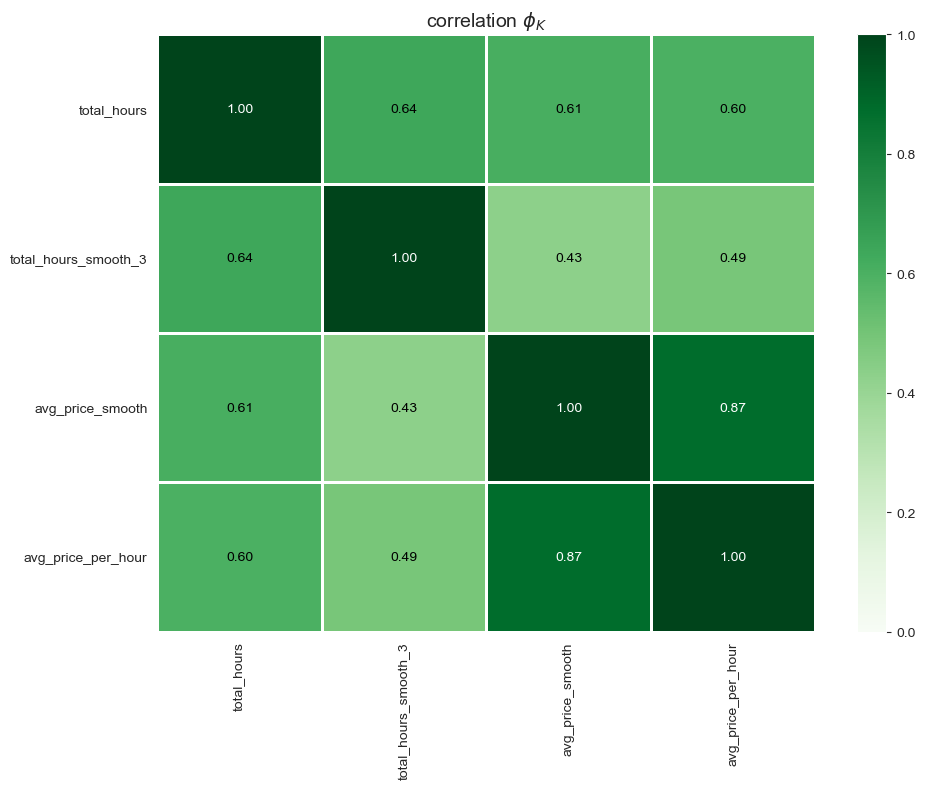

In [18]:
##Корелляция посещаемости и 
col_phik = ['avg_price_per_hour', 'avg_price_smooth',  'total_hours_smooth_3',   "total_hours"]

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_trend[col_phik], interval_cols = ['avg_price_smooth', 'total_hours_smooth_3', 'avg_price_per_hour', "total_hours"] )

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    figsize=(10, 8)
);

Самую высокую (при этом ьсредней значимости) корелляцию показывают Признаки - Цена за час. и Количество часов в месяц.

Тепловая карта заполняемости, по часам и дням недели. Для всех залов. В пиковые месяцы с Октября по Апрель. Скорее всего летом поднять посещаемость все равно не получится, очень низкий спрос.

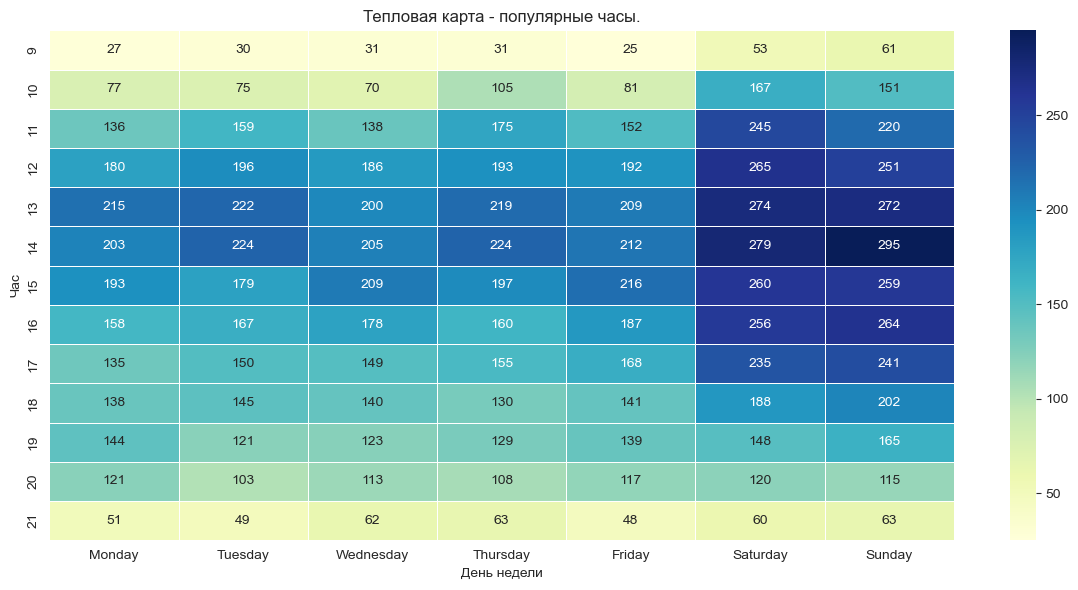

In [19]:
# Загрузка и подготовка
df = df_main

# Расширение строк по часам бронирования
rows = []
for _, row in df.iterrows():
    for hour in range(int(row["start_h"]), int(row["start_h"] + row["dur_h"])):
        rows.append({
            "weekday": row["weekday"],
            "hour": hour
        })

df_hours = pd.DataFrame(rows)

# Создаём тепловую таблицу
heat_data = df_hours.pivot_table(
    index="hour", columns="weekday", aggfunc="size", fill_value=0
)

# Упорядочим дни недели
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heat_data = heat_data[weekday_order]

# Отрисовка
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")
plt.title("Тепловая карта - популярные часы.")
plt.xlabel("День недели")
plt.ylabel("Час")
plt.tight_layout()
plt.show()

- Сезонность явная- с Октября по Март. Лето - все на натуре Заполняемость слабая.
- В выходные заполняемость выше. Возможно в будни стоит снизить цену в паре залов, что бы посмотреть на эффект.
- Если считать что в месяце 390 доступных часов, то в пиковые зимние месяцы Средняя заполняемость составляет 50%, в летние месяцы падает до 20%.
- Самые популярные часы с 12:00 до 20:00
- 

### Анализ дополнительных услуг

In [20]:
from collections import Counter

df = df_main
df["extras"] = df["extras"].fillna("")

# Паттерн: "Название x Число"
pattern = r"([А-Яа-яA-Za-z\s\.\-]+?)\s*x\s*(\d+)"
service_counter = Counter()
service_total_value = Counter()

# Простой парсинг услуг
for i, row in df.iterrows():
    matches = re.findall(pattern, row["extras"])
    for name, qty in matches:
        name_clean = name.strip().lower()
        quantity = int(qty)
        service_counter[name_clean] += quantity
        service_total_value[name_clean] += quantity  # стоимость пока временная

# Преобразуем в таблицу
services_df = pd.DataFrame({
    "service": list(service_counter.keys()),
    "total_count": list(service_counter.values()),
    "total_value_placeholder": list(service_total_value.values())
}).sort_values("total_count", ascending=False).reset_index(drop=True)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Анализ дополнительных услуг", dataframe=services_df)
services_df.head()

,service,total_count,total_value_placeholder
0,гримерная,1209,1209
1,рная,399,399
2,дым-машина,314,314
3,рка,257,257
4,журавль стойка,112,112


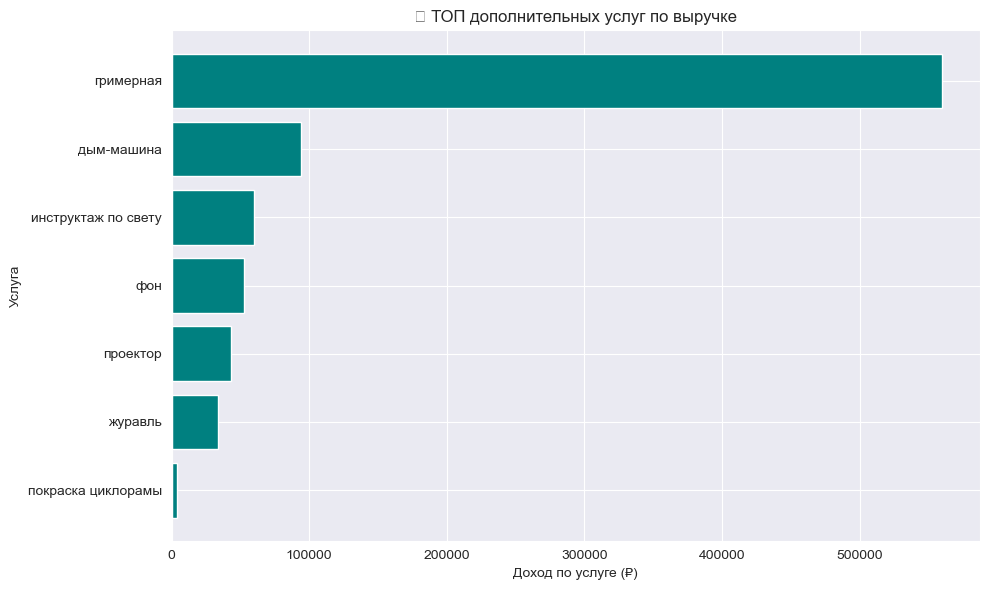

In [21]:
# 1. Очистка названий услуг и замена обрезанных версий на корректные
replace_map = {
    "рная": "гримерная",
    "рка": "гримерная",
    "гримерка": "гримерная",
    "инструктаж по свету": "инструктаж по свету",
    "ассистент на съёмку": "ассистент",
    "журавль стойка": "журавль",
    "бумажный фон": "фон",
    "проектор": "проектор",
    "дым-машина": "дым-машина"
}

# Удалим пробелы и приведем к нижнему регистру
services_df["service_clean"] = services_df["service"].str.strip().str.lower()
services_df["service_clean"] = services_df["service_clean"].replace(replace_map)

# 2. Добавим цены для расчёта выручки
price_map = {
    "гримерная": 300,
    "покраска циклорамы": 1000,
    "проектор": 500,
    "инструктаж по свету": 1500,
    "журавль": 300,
    "ассистент": 500,
    "фон": 500,
    "дым-машина": 300
}

services_df["price"] = services_df["service_clean"].map(price_map)
services_df["total_revenue"] = services_df["total_count"] * services_df["price"]

# 3. Группируем по очищенным названиям
grouped = services_df.groupby("service_clean").agg({
    "total_count": "sum",
    "total_revenue": "sum"
}).sort_values("total_revenue", ascending=False).reset_index()


grouped = grouped.head(7)

# 4. Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(grouped["service_clean"], grouped["total_revenue"], color="teal")
plt.xlabel("Доход по услуге (₽)")
plt.ylabel("Услуга")
plt.title("📊 ТОП дополнительных услуг по выручке")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

вывод:

Гримерная — главный источник доп.дохода;

Затем идут: покраска циклорамы, проектор, дым-машина;

Эти данные можно использовать для:

формирования пакетов услуг,

upsell предложений при бронировании,

приоритизации оборудования в закупках и поддержке.


**Промежуточные выводы**

1. **Загрузка залов**

* Залы **Дзен** и **ЧБ** стабилизировали загрузку к марту 2023 года.
* Суммарное количество арендованных часов **постепенно снижается**, особенно по сравнению с аналогичными периодами предыдущих лет.
* При этом **доход остаётся стабильным или растёт**, что указывает на **повышение цен**.

2. **Ценообразование**

* Анализ поля `amount` показывает, что **средняя почасовая ставка** заметно увеличилась в течение 2023 года.
* После повышения цены наблюдается **корреляция с падением количества арендованных часов** (обратная зависимость).
* Однако **суммарная выручка не страдает** — гипотеза о том, что повышение цен компенсировало снижение загрузки, подтверждается.

3. **Дополнительные услуги**

* Абсолютный лидер по популярности и выручке — **гримерная**.
* Также востребованы: **покраска циклорамы**, **проектор**, **дым-машина**.
* Есть ошибки и артефакты в исходных названиях (`рка`, `рная`), что повлияло на чистоту данных — исправлено.

---

 **Рекомендации и гипотезы для проверки**

Ценообразование

* **Фиксировать изменение ставок** (ввести гибкую таблицу по дням недели и залам);
* **Проверить порог чувствительности** — в какой момент снижение загрузки превышает рост цены;
* Провести **A/B-анализ по цене** (если возможно).

Дополнительные услуги

* Разработать **пакетные предложения** (например, "гримерная + свет + ассистент");
* Продвигать **самые прибыльные услуги** при онлайн-бронировании (подсветка, upsell);
* Подумать о **динамическом ценообразовании** (например, у покраски — цена по срочности).

Операционное планирование

* На основе тепловых карт — **внедрить промо или скидки в “мёртвые часы”**;
* **Перераспределить маркетинговый акцент** между залами в зависимости от их загрузки;
* Использовать аналитическую панель для **мониторинга отклонений в загрузке и доходе** по залам.

Анализ рынка фотостудий в районе Электрозаводская

Район Электрозаводская в Москве известен высокой концентрацией фотостудий благодаря наличию просторных индустриальных помещений, подходящих для креативных пространств. Это создает конкурентную среду, где студии предлагают разнообразные услуги и ценовые предложения.

 Конкуренция и ценовой диапазон

Цены на аренду залов в фотостудиях района варьируются в зависимости от оснащения и времени суток. Средняя стоимость аренды составляет от 1,500 до 3,000 рублей в час. Некоторые студии предлагают скидки в непиковые часы или при длительной аренде.

---

Прогноз влияния снижения цен на загруженность залов

Снижение цен может повлиять на загруженность залов следующим образом:

* **Увеличение спроса:** Более низкие цены могут привлечь клиентов с ограниченным бюджетом, увеличивая общее количество бронирований.

* **Конкурентное преимущество:** Предложение более выгодных условий может выделить студию среди конкурентов, особенно в условиях высокой конкуренции.

* **Риск снижения дохода:** Если увеличение количества бронирований не компенсирует снижение цены, общий доход может уменьшиться.

Рекомендации

* **Анализ текущей загрузки:** Оцените текущую загруженность залов по времени суток и дням недели, чтобы определить периоды с наименьшей загрузкой.

* **Таргетированное снижение цен:** Рассмотрите возможность снижения цен в периоды низкой загрузки, чтобы стимулировать спрос без потери дохода в пиковые часы.

* **Промоакции и пакеты услуг:** Предложите специальные предложения или пакеты услуг, чтобы увеличить средний чек и привлечь новых клиентов.

* **Мониторинг конкурентов:** Следите за ценовой политикой конкурентов в районе, чтобы своевременно адаптировать свои предложения.


## Прогнозирование

###  Прогноз выручки за месяц (общей)
Что прогнозируем: доход по rent_estimate, amount, extras_cost.

Зачем: для планирования бюджета, оценки окупаемости.

Методы:
Месячная или недельная агрегация + Prophet;
CatBoost, XGBoost или RandomForest с признаками: зал, месяц, день недели, длительность.

12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing


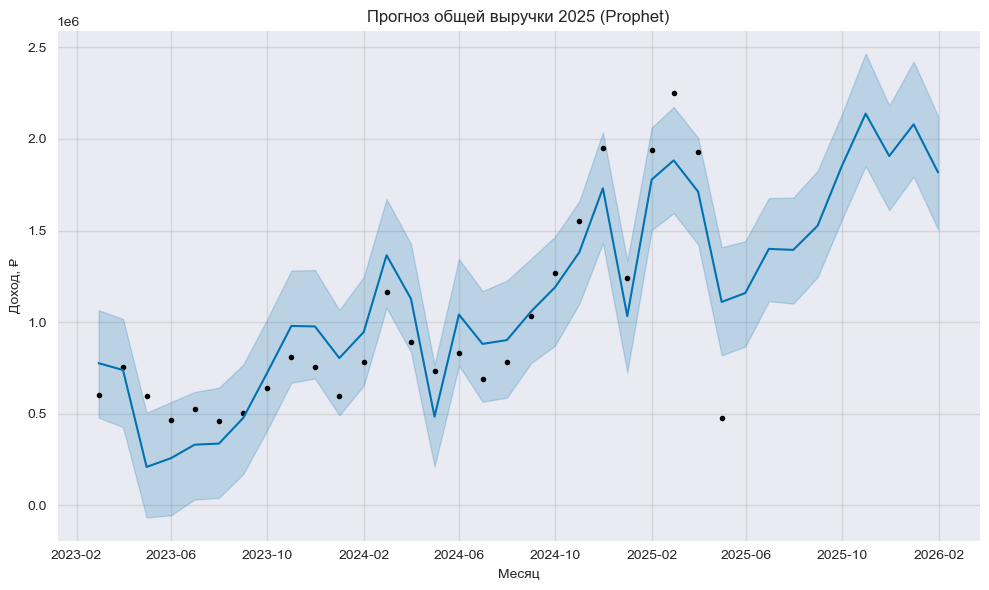

,ds,yhat,yhat_lower,yhat_upper
30,2025-08-31,"1,526,425.60","1,245,748.38","1,826,456.93"
31,2025-09-30,"1,844,436.47","1,551,409.34","2,126,554.92"
32,2025-10-31,"2,137,630.01","1,851,642.03","2,465,246.60"
33,2025-11-30,"1,906,394.77","1,610,669.56","2,181,366.65"
34,2025-12-31,"2,079,587.49","1,794,717.98","2,421,593.96"
35,2026-01-31,"1,817,346.73","1,506,807.20","2,124,650.49"


In [22]:
from prophet import Prophet

# Подготовка данных
df = pd.read_csv("dataset/studio_data_anc.csv", parse_dates=["booking_date"])
df = df[df["booking_date"] >= "2023-03-01"].copy()
df["rent_total"] = df['amount'] #df["rent_estimate"] + df["extras_cost"]
df["year_month"] = df["booking_date"].dt.to_period("M").dt.to_timestamp()

# Агрегация по месяцам
monthly_revenue = df.groupby("year_month")["rent_total"].sum().reset_index()
monthly_revenue.columns = ["ds", "y"]

# Модель Prophet
model = Prophet()
model.fit(monthly_revenue)

# Прогноз на 6 месяцев вперёд
future = model.make_future_dataframe(periods=9, freq='M')
forecast = model.predict(future)

# Визуализация
model.plot(forecast)
plt.title("Прогноз общей выручки 2025 (Prophet)")
plt.xlabel("Месяц")
plt.ylabel("Доход, ₽")
plt.grid(True)
plt.tight_layout()
plt.show()

# Таблица
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(6)

###  Прогноз бронирований на 2025 ("Дзен", "ЧБ")
Что прогнозируем: доход по rent_estimate, amount, extras_cost.

Зачем: для планирования бюджета, оценки окупаемости.

Методы:
Месячная или недельная агрегация + Prophet;
CatBoost, XGBoost или RandomForest с признаками: зал, месяц, день недели, длительность.

12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1] done processing


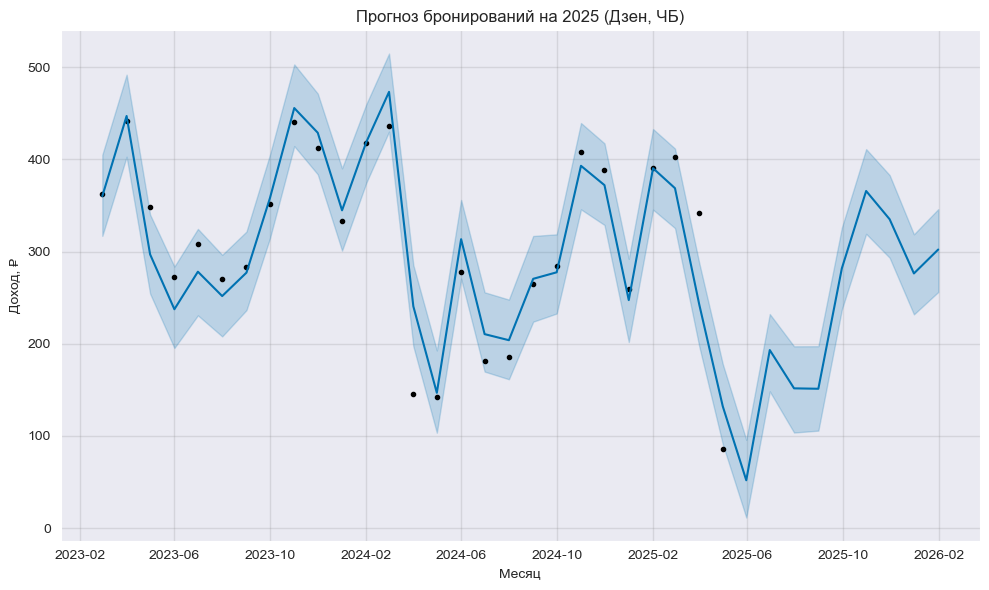

,ds,yhat,yhat_lower,yhat_upper
30,2025-08-31,151.19,105.76,197.37
31,2025-09-30,281.86,237.29,325.98
32,2025-10-31,365.79,319.30,411.24
33,2025-11-30,335.14,293.38,383.02
34,2025-12-31,276.33,231.90,318.78
35,2026-01-31,302.26,256.15,346.06


In [23]:
# Перерасчёт тренда, если данные были утеряны
selected_halls = ["Дзен", "ЧБ"]
df = df[
    (df["hall"].isin(selected_halls)) 
].copy()

# Агрегация по месяцам
monthly_revenue = df.groupby("year_month")["dur_h"].sum().reset_index()
monthly_revenue.columns = ["ds", "y"]

# Модель Prophet
model = Prophet()
model.fit(monthly_revenue)

# Прогноз на 6 месяцев вперёд
future = model.make_future_dataframe(periods=9, freq='M')
forecast = model.predict(future)

# Визуализация
model.plot(forecast)
plt.title("Прогноз бронирований на 2025 (Дзен, ЧБ)")
plt.xlabel("Месяц")
plt.ylabel("Доход, ₽")
plt.grid(True)
plt.tight_layout()
plt.show()

# Таблица
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(6)

### Раннее определение “провальных” недель. Прогноз загруженности залов (по неделям)**
→ Выгода: возможность запустить рекламную акцию или коллаборацию заранее.
→ Выгода: планирование бюджета, закупок, персонала (освободить студию или наоборот нанять ассистента на горячие дни).

Что прогнозируем: количество часов аренды.
Зачем: для планирования персонала, акций, цен.
Методы:
TimeSeries модели (например, Prophet, SARIMA, Exponential Smoothing);
Скользящее среднее или медиана по сезонам (ручное сглаживание).

In [24]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Подготовка данных
df = pd.read_csv("dataset/studio_data_anc.csv", parse_dates=["booking_date"])
df = df[df["booking_date"] >= "2023-03-01"].copy()

df["week"] = df["booking_date"].dt.isocalendar().week
df["year"] = df["booking_date"].dt.year
df["month"] = df["booking_date"].dt.month
df["weekday"] = df["booking_date"].dt.day_name()
df['price_per_hour'] = (df['amount'] - df['extras_cost']) / df['dur_h']

# 3. Группировка по неделям, залам и годам
weekly_grouped = df.groupby(["hall", "year", "week"]).agg({
    "dur_h": "sum",
    "price_per_hour": "mean"
}).reset_index()

# 4. Подготовка данных для модели
X = weekly_grouped[["hall", "year", "week"]]
y = weekly_grouped["dur_h"]
X_encoded = pd.get_dummies(X, columns=["hall"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Модель
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# 6. Предсказание и MAE
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f} часов")

# 7. Прогноз на все недели из датасета
weekly_grouped_encoded = pd.get_dummies(weekly_grouped[["hall", "year", "week"]], columns=["hall"])
weekly_grouped_encoded = weekly_grouped_encoded.reindex(columns=X_encoded.columns, fill_value=0)
weekly_grouped["predicted_dur_h"] = np.clip(model.predict(weekly_grouped_encoded), 0, None)

# 8. Топ-5 провальных недель
worst_weeks = weekly_grouped.sort_values("predicted_dur_h").head(20)
print("📉 Топ-20 самых слабых недель по предсказанию:")
display(worst_weeks)

MAE: 5.97 часов
📉 Топ-20 самых слабых недель по предсказанию:


,hall,year,week,dur_h,price_per_hour,predicted_dur_h
44,Grigio,2024,10,1,"1,100.00",0.00
5,Bianco,2024,33,1,"1,600.00",0.00
24,Bianco,2025,1,4,"1,825.00",0.00
50,Grigio,2024,33,1,"1,850.00",0.00
45,Grigio,2024,11,1,"1,100.00",0.28
46,Grigio,2024,12,1,"1,100.00",0.68
1,Bianco,2024,10,1,"1,400.00",0.92
68,Grigio,2025,1,3,"1,533.33",1.00
49,Grigio,2024,31,2,"1,100.00",1.75
2,Bianco,2024,12,2,"1,675.00",2.40


Прошноз на предобученой модели для Зала по месяцу.

In [25]:
import calendar

# Ввод
target_year = 2025
target_month = 12
target_hall = "Дзен"

# Функция генерации недель
def get_weeks_in_month(year, month):
    start_date = datetime(year, month, 1)
    end_date = datetime(year, month, calendar.monthrange(year, month)[1])
    start_week = start_date - timedelta(days=start_date.weekday())
    end_week = end_date + timedelta(days=6 - end_date.weekday())

    current = start_week
    weeks = []
    while current <= end_week:
        week_start = current
        week_end = current + timedelta(days=6)
        week_number = week_start.isocalendar().week
        weeks.append((week_number, week_start, week_end))
        current += timedelta(days=7)
    return weeks



weeks = get_weeks_in_month(target_year, target_month)

# Прогноз
input_data = []
for week_number, week_start, week_end in weeks:
    input_data.append({
        "hall": target_hall,
        "year": week_start.year,
        "week": week_number,
        "range": f"{week_start.strftime('%d.%m.%Y')} — {week_end.strftime('%d.%m.%Y')}"
    })

df_input = pd.DataFrame(input_data)
# 1. One-hot encoding по hall
df_input_encoded = pd.get_dummies(df_input[["hall", "year", "week"]], columns=["hall"])

# 2. Приводим к нужному виду и порядку столбцов
df_input_encoded = df_input_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# 3. Предсказание
df_input["predicted_dur_h"] = np.clip(model.predict(df_input_encoded), 0, None)
print ('Зал -', target_hall )
# 4. Вывод
df_input[["range", "predicted_dur_h"]]

Зал - Дзен


,range,predicted_dur_h
0,01.12.2025 — 07.12.2025,46.92
1,08.12.2025 — 14.12.2025,50.19
2,15.12.2025 — 21.12.2025,52.37
3,22.12.2025 — 28.12.2025,29.98
4,29.12.2025 — 04.01.2026,13.71


## Финальный вывод.
**Идеи для развития:**    
Акции или партнёрства для малопосещаемых залов (Bianco, Grigio).
Ретаргетинг по отменённым и просроченным бронированиям.
Видеосъёмка как новый продукт — отдельное оборудование, тарифы, продвижение.
Дифференцированное ценообразование по часам (дешевле утром и вечером — выше загрузка вне пика).
Автоматизация тайминга и оповещений — особенно для залов с высокой отменяемостью.

Видеосьемка? Почему не развивается? Шумы, тишина?